## Logistic Regression for Defaults

With the loan data fully prepared, we will discuss the logistic regression model which is a standard in risk modeling. We will understand the components of this model as well as how to score its performance. Once we've created predictions, we can explore the financial impact of utilizing this model.

### Logistic regression basics
You've now cleaned up the data and created the new data set cr_loan_clean.

Think back to the final scatter plot from chapter 1 which showed more defaults with high loan_int_rate. Interest rates are easy to understand, but what how useful are they for predicting the probability of default?

Since you haven't tried predicting the probability of default yet, test out creating and training a logistic regression model with just loan_int_rate. Also check the model's internal parameters, which are like settings, to see the structure of the model with this one column.

The data cr_loan_clean has already been loaded in the workspace.

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# read data
cr_loan = pd.read_csv("cr_loan2.csv")

# Impute the null values with the median value for all employment lengths
cr_loan['person_emp_length'].fillna((cr_loan['person_emp_length'].median()), inplace=True)


# Store the array on indices
indices = cr_loan[cr_loan['loan_int_rate'].isnull()].index

# Save the new data without missing data
cr_loan_clean = cr_loan.drop(indices)

# Create the X and y data sets
X = cr_loan_clean[['loan_int_rate']]
y = cr_loan_clean[['loan_status']]

# Create and fit a logistic regression model
clf_logistic_single = LogisticRegression(solver='lbfgs')
clf_logistic_single.fit(X, np.ravel(y))

# Print the parameters of the model
print(clf_logistic_single.get_params())

# Print the intercept of the model
print(clf_logistic_single.intercept_)

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
[-4.4586918]


### Multivariate logistic regression
Generally, you won't use only loan_int_rate to predict the probability of default. You will want to use all the data you have to make predictions.

With this in mind, try training a new model with different columns, called features, from the cr_loan_clean data. Will this model differ from the first one? For this, you can easily check the .intercept_ of the logistic regression. Remember that this is the y-intercept of the function and the overall log-odds of non-default.

In [4]:
# Create X data for the model
X_multi = cr_loan_clean[['loan_int_rate', 'person_emp_length']]

# Create a set of y data for training
y = cr_loan_clean[['loan_status']]

# Create and train a new logistic regression
clf_logistic_multi =  LogisticRegression(solver='lbfgs').fit(X_multi, np.ravel(y))

# Print the intercept of the model
print(clf_logistic_multi.intercept_)

[-4.2253171]


### Creating training and test sets
You've just trained LogisticRegression() models on different columns.

You know that the data should be separated into training and test sets. test_train_split() is used to create both at the same time. The training set is used to make predictions, while the test set is used for evaluation. Without evaluating the model, you have no way to tell how well it will perform on new loan data.

In addition to the intercept_, which is an attribute of the model, LogisticRegression() models also have the .coef_ attribute. This shows how important each training column is for predicting the probability of default.

In [7]:
from sklearn.model_selection import train_test_split

# Create the X and y data sets
X = cr_loan_clean[['loan_int_rate', 'person_emp_length', 'person_income']]
y = cr_loan_clean[['loan_status']]

# Use test_train_split to create the training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

# Create and fit the logistic regression mode
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

# Print the models coefficients
print(clf_logistic.coef_)

[[ 8.34020099e-02 -6.02470833e-02 -3.28983416e-05]]


### One-hot encoding credit data
It's time to prepare the non-numeric columns so they can be added to your LogisticRegression() model.

Once the new columns have been created using one-hot encoding, you can concatenate them with the numeric columns to create a new data frame which will be used throughout the rest of the course for predicting probability of default.

Remember to only one-hot encode the non-numeric columns. Doing this to the numeric columns would create an incredibly wide data set!

In [8]:
# Create two data sets for numeric and non-numeric data
cred_num = cr_loan_clean.select_dtypes(exclude=['object'])
cred_str = cr_loan_clean.select_dtypes(include=['object'])

# One-hot encode the non-numeric columns
cred_str_onehot = pd.get_dummies(cred_str)

# Union the one-hot encoded columns to the numeric ones
cr_loan_prep = pd.concat([cred_num, cred_str_onehot], axis=1)

# Print a few rows  of the new data set
print(cr_loan_prep.head())

   person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
0          22          59000              123.0      35000          16.02   
1          21           9600                5.0       1000          11.14   
2          25           9600                1.0       5500          12.87   
3          23          65500                4.0      35000          15.23   
4          24          54400                8.0      35000          14.27   

   loan_status  loan_percent_income  cb_person_cred_hist_length  \
0            1                 0.59                           3   
1            0                 0.10                           2   
2            1                 0.57                           3   
3            1                 0.53                           2   
4            1                 0.55                           4   

   person_home_ownership_MORTGAGE  person_home_ownership_OTHER  ...  \
0                               0                            0 

### Predicting probability of default
All of the data processing is complete and it's time to begin creating predictions for probability of default. You want to train a LogisticRegression() model on the data, and examine how it predicts the probability of default.

So that you can better grasp what the model produces with predict_proba, you should look at an example record alongside the predicted probability of default. How do the first five predictions look against the actual values of loan_status?

In [9]:
# Train the logistic regression model on the training data
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))

# Create predictions of probability for loan status using test data
preds = clf_logistic.predict_proba(X_test)

# Create dataframes of first five predictions, and first five true labels
preds_df = pd.DataFrame(preds[:,1][0:5], columns = ['prob_default'])
true_df = y_test.head()

# Concatenate and print the two data frames for comparison
print(pd.concat([true_df.reset_index(drop = True), preds_df], axis = 1))

   loan_status  prob_default
0            0      0.203595
1            0      0.137401
2            0      0.119622
3            0      0.307440
4            0      0.505785


### Default classification reporting
It's time to take a closer look at the evaluation of the model. Here is where setting the threshold for probability of default will help you analyze the model's performance through classification reporting.

Creating a data frame of the probabilities makes them easier to work with, because you can use all the power of pandas. Apply the threshold to the data and check the value counts for both classes of loan_status to see how many predictions of each are being created. This will help with insight into the scores from the classification report.

In [12]:
from sklearn.metrics import classification_report

# Create a dataframe for the probabilities of default
pred_df = pd.DataFrame(preds[:,1], columns = ['prob_default'])

# Reassign loan status based on the threshold
pred_df['loan_status'] = pred_df['prob_default'].apply(lambda x: 1 if x > 0.50 else 0)

# Print the row counts for each loan status
print(pred_df['loan_status'].value_counts())

# Print the classification report
target_names = ['Non-Default', 'Default']
print(classification_report(y_test, pred_df['loan_status'], target_names=target_names))

0    10861
1      925
Name: loan_status, dtype: int64
              precision    recall  f1-score   support

 Non-Default       0.81      0.96      0.88      9194
     Default       0.62      0.22      0.33      2592

    accuracy                           0.80     11786
   macro avg       0.72      0.59      0.61     11786
weighted avg       0.77      0.80      0.76     11786



### Selecting report metrics
The classification_report() has many different metrics within it, but you may not always want to print out the full report. Sometimes you just want specific values to compare models or use for other purposes.

There is a function within scikit-learn that pulls out the values for you. That function is precision_recall_fscore_support() and it takes in the same parameters as classification_report.

In [15]:
from sklearn.metrics import precision_recall_fscore_support
# Print all the non-average values from the report
print(precision_recall_fscore_support(y_test, pred_df['loan_status']))

(array([0.81447381, 0.62378378]), array([0.96214923, 0.22260802]), array([0.88217402, 0.32812056]), array([9194, 2592], dtype=int64))


In [17]:
# Print the first two numbers from the report
print(precision_recall_fscore_support(y_test, pred_df['loan_status'])[0])

[0.81447381 0.62378378]


0.7995078907178008


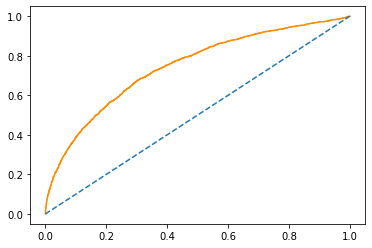

0.7437090992313827


In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Create predictions and store them in a variable
preds = clf_logistic.predict_proba(X_test)

# Print the accuracy score the model
print(clf_logistic.score(X_test,y_test))

# Plot the ROC curve of the probabilities of default
prob_default = preds[:, 1]
fallout, sensitivity, thresholds = roc_curve(y_test, prob_default)
plt.plot(fallout, sensitivity, color = 'darkorange')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

# Compute the AUC and store it in a variable
auc = roc_auc_score(y_test, prob_default)
print(auc)

Thresholds and confusion matrices
You've looked at setting thresholds for defaults, but how does this impact overall performance? To do this, you can start by looking at the effects with confusion matrices.

Recall the confusion matrix as shown here:

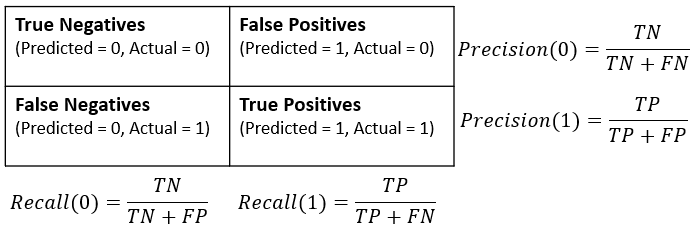

Set different values for the threshold on probability of default, and use a confusion matrix to see how the changing values affect the model's performance.

The data frame of predictions, preds_df, as well as the model clf_logistic have been loaded in the workspace.

In [24]:
from sklearn.metrics import confusion_matrix

# Set the threshold for defaults to 0.5
pred_df['loan_status'] = pred_df['prob_default'].apply(lambda x: 1 if x > 0.5 else 0)

# Print the confusion matrix
print(confusion_matrix(y_test,pred_df['loan_status']))

[[8846  348]
 [2015  577]]


In [25]:
# Set the threshold for defaults to 0.4
pred_df['loan_status'] = pred_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

# Print the confusion matrix
print(confusion_matrix(y_test,pred_df['loan_status']))

[[8074 1120]
 [1477 1115]]


### How thresholds affect performance
Setting the threshold to 0.4 shows promising results for model evaluation. Now you can assess the financial impact using the default recall which is selected from the classification reporting using the function precision_recall_fscore_support().

For this, you will estimate the amount of unexpected loss using the default recall to find what proportion of defaults you did not catch with the new threshold. This will be a dollar amount which tells you how much in losses you would have if all the unfound defaults were to default all at once.

In [27]:
 # The average loan value, avg_loan_amnt has been calculated:
    
avg_loan_amnt = cr_loan_clean['loan_amnt'].mean()

# Reassign the values of loan status based on the new threshold
pred_df['loan_status'] = pred_df['prob_default'].apply(lambda x: 1 if x > 0.4 else 0)

# Store the number of loan defaults from the prediction data
num_defaults = pred_df['loan_status'].value_counts()[1]

# Store the default recall from the classification report
default_recall = precision_recall_fscore_support(y_test,pred_df['loan_status'])[1][1]

# Calculate the estimated impact of the new default recall rate
print(num_defaults * avg_loan_amnt * (1 - default_recall))

12206848.964421853


### Threshold selection
You know there is a trade off between metrics like default recall, non-default recall, and model accuracy. One easy way to approximate a good starting threshold value is to look at a plot of all three using matplotlib. With this graph, you can see how each of these metrics look as you change the threshold values and find the point at which the performance of all three is good enough to use for the credit data.

The threshold values thresh, default recall values def_recalls, the non-default recall values nondef_recalls and the accuracy scores accs have been loaded into the workspace. 

Have a closer look at the plot in the video.Think about the threshold values from thresh and how they affect each of these three metrics. Approximately what starting threshold value would maximize these scores evenly?

Looking the graph in the video, the easiest pattern to see on this graph is the thresold = 0.275, because it's the point where all three lines converge. This threshold would make a great starting point, but declaring all loans about 0.275 to be a default is probably not practical.